In [1]:
from brian2 import *
prefs.codegen.target = "numpy"


%matplotlib inline

# The Connor-Stevens Model with Brian2

equations were adapted from Abbott's "Theoretical Neuroscience", p 197 ...


$$ i_m = \overline g_L + \overline g_{Na}m^3h(V - E_{Na}) + \overline g_Kn^4(V - E_K) + \overline g_Aa^3b(V - E_A) $$

and p 224
## Modifed HH gating variables
$$\begin{align}
\alpha_m &= \frac{0.38(V + 29.7)}{1 - \exp(-0.1(V - 29.7))}\\
\beta_m &= 15.2\exp(-0.0556(V + 54.7))\\
\alpha_h &= 0.266\exp(-0.05(V + 48))\\
\beta_h &= \frac{3.8}{1 + \exp(-0.1(V + 18))}\\
\alpha_n &= \frac{0.02(V + 45.7)}{1 - \exp(-0.1(V + 45.7))}\\
\beta_n &= 0.25\exp(-0.0125(V + 55.7))
\end{align}
$$
## A-current variables
$$\begin{align}
a_{\infty} &= \left(\frac{0.0761\exp(0.0314(V + 94.22))}{1 + \exp(0.0346(V + 1.17))}\right)^{1/3} \\
\tau_{a} &= 0.3632 + \frac{1.158}{1 + \exp(0.0497(V + 55.96))} \\
b_{\infty} &= \left(\frac{1}{1 + \exp(0.0688(V + 53.3))}\right)^4 \\
\tau_{b} &= 1.24 + \frac{2.678}{1 + \exp(0.0624(V + 50))}
\end{align}$$

In [2]:
conductance_u = msiemens/(mmeter**2)  # _u is for units

E_L = -17 * mvolt
g_L = 3e-3 * conductance_u
E_Na = 55 * mvolt
g_Na = 1.2 * conductance_u
E_K = -72 * mvolt
g_K = 0.2 * conductance_u
E_A = -75 * mvolt
g_A = 0.477 * conductance_u
E_CaT = 120 * mV
g_CaT = 0.013 * conductance_u

morpho = Soma(diameter=30*um)

eqs = '''
Im = -g_L * (v - E_L) 
- g_Na * (m**3) * h * (v - E_Na)
- g_K * (n**4) * (v - E_K)
- g_A * (a**3) * b * (v - E_A) : amp/meter**2

I : amp (point current)

alpha_m = 3.8 / exprel(-0.1*(v/mV + 29.7)) / ms : Hz
beta_m = 15.2*exp(-0.0556*(v/mV + 54.7)) / ms : 1/second
alpha_h = 0.266*exp(-0.05*(v/mV + 48)) / ms : 1/second
beta_h = 3.8/(1 + exp(-0.1*(v/mV + 18))) / ms : 1/second
alpha_n = .2/exprel(-.1*(v/mV + 45.7)) / ms : Hz
beta_n = 0.25*exp(-0.0125*(v/mV + 55.7)) / ms : 1/second

tau_m = 1 / (alpha_m + beta_m) : second
m_inf = alpha_m / (alpha_m + beta_m) : 1
dm/dt = (m_inf - m) / tau_m : 1

tau_h = 1 / (alpha_h + beta_h) : second
h_inf = alpha_h / (alpha_h + beta_h) : 1
dh/dt = (h_inf - h) / tau_h : 1

tau_n = 1 / (alpha_n + beta_n) : second
n_inf = alpha_n / (alpha_n + beta_n) : 1
dn/dt = (n_inf - n) / tau_n : 1

tau_a = 0.3632*ms + 1.158*ms/(1 + exp(0.0497*(v/mV + 55.96))) : second
a_inf = (0.0761*exp(0.0314*(v/mV + 94.22)) / (1 + exp(0.0346*(v/mV + 1.17))))**(1./3) : 1
da/dt = (a_inf - a) / tau_a : 1

tau_b = 1.24*ms + 2.678*ms / (1 + exp(0.0624 * (v/mV + 50))) : second
b_inf = (1 / (1 + exp(0.0688*(v/mV + 53.3))))**4 : 1
db/dt = (b_inf - b) / tau_b : 1
'''


spat_neuron = SpatialNeuron(morphology=morpho, model=eqs, method='exponential_euler', Cm=1*uF/cm**2, Ri=35.4*ohm*cm)
statemon = StateMonitor(spat_neuron, True, record=True, dt=0.1*ms)

spat_neuron.v = -68*mV

spat_neuron.h = 0.
spat_neuron.m = 0.5
spat_neuron.n = 0.5
spat_neuron.a = 0.
spat_neuron.b = 0.

spat_neuron.I = 0*nA
run(10*ms)
spat_neuron.main.I = .8*nA
run(30*ms)
spat_neuron.I = 0*nA
run(10*ms)

Text(0, 0.5, 'mV')

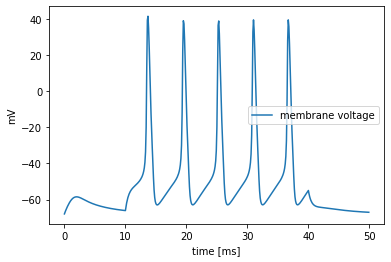

In [3]:
plot(statemon.t/ms, statemon.v[0]/mV, label='membrane voltage')
legend()
xlabel('time [ms]')
ylabel('mV')

Text(0, 0.5, 'gates dynamics')

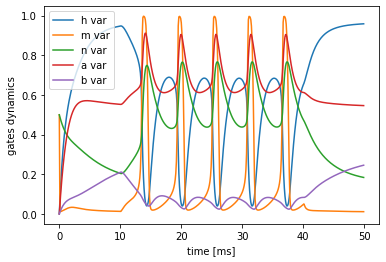

In [5]:
# h, m, n, a and b variables
plot(statemon.t/ms, statemon.h[0], label='h var')
plot(statemon.t/ms, statemon.m[0], label='m var')
plot(statemon.t/ms, statemon.n[0], label='n var')
plot(statemon.t/ms, statemon.a[0], label='a var')
plot(statemon.t/ms, statemon.b[0], label='b var')
legend()
xlabel('time [ms]')
ylabel('gates dynamics')

# Postinhibitory Rebound and Bursting
## $Ca^{2+}$ transient conductance
conductance modeled here was introduced by Huguenard and McCormick (1992) on the basis of data from thalamic relay cells



$$ i_{CaT} = \overline g_{CaT}M^2H(V - E_{Ca})$$ 


\- membrane current due to the transient $Ca^{2+}$



$$ M_{\infty} = \frac{1}{1 + \exp(-(V + 57)/6.2)}$$

$$ H_{\infty} = \frac{1}{1 + \exp((V + 81)/4)}$$

$$ \tau_M = 0.612 + \frac{1}{\exp(-(V + 132)/16.7) + \exp((V + 16.8)/18.2)}$$

$$ \tau_H = 
\begin{cases}
\exp((V + 467)/66.6)  & \text{if $V < -80 mV$} \\
28 + \exp(-(V + 22)/10.5)  & \text{if $V >= 80 mV$}
\end{cases}$$

In [2]:
conductance_u = msiemens/(mmeter**2)  # _u is for units

E_L = -17 * mvolt
g_L = 3e-3 * conductance_u
E_Na = 55 * mvolt
g_Na = 1.2 * conductance_u
E_K = -72 * mvolt
g_K = 0.2 * conductance_u
E_A = -75 * mvolt  # -75
g_A = 0.477 * conductance_u
E_CaT = 120 * mV
g_CaT = 0.013 * conductance_u

morpho = Soma(diameter=30*um)

eqs = '''
Im = -g_L * (v - E_L) 
- g_Na * (m**3) * h * (v - E_Na)
- g_K * (n**4) * (v - E_K)
- g_A * (a**3) * b * (v - E_A)
- g_CaT * (M**2) * H * (v - E_CaT) : amp/meter**2

I : amp (point current)

alpha_m = 3.8 / exprel(-0.1*(v/mV + 29.7)) / ms : Hz
beta_m = 15.2*exp(-0.0556*(v/mV + 54.7)) / ms : 1/second
alpha_h = 0.266*exp(-0.05*(v/mV + 48)) / ms : 1/second
beta_h = 3.8/(1 + exp(-0.1*(v/mV + 18))) / ms : 1/second
alpha_n = .2/exprel(-.1*(v/mV + 45.7)) / ms : Hz
beta_n = 0.25*exp(-0.0125*(v/mV + 55.7)) / ms : 1/second

tau_m = 1 / (alpha_m + beta_m) : second
m_inf = alpha_m / (alpha_m + beta_m) : 1
dm/dt = (m_inf - m) / tau_m : 1

tau_h = 1 / (alpha_h + beta_h) : second
h_inf = alpha_h / (alpha_h + beta_h) : 1
dh/dt = (h_inf - h) / tau_h : 1

tau_n = 1 / (alpha_n + beta_n) : second
n_inf = alpha_n / (alpha_n + beta_n) : 1
dn/dt = (n_inf - n) / tau_n : 1

tau_a = 0.3632*ms + 1.158*ms/(1 + exp(0.0497*(v/mV + 55.96))) : second
a_inf = (0.0761*exp(0.0314*(v/mV + 94.22)) / (1 + exp(0.0346*(v/mV + 1.17))))**(1./3) : 1
da/dt = (a_inf - a) / tau_a : 1

tau_b = 1.24*ms + 2.678*ms / (1 + exp(0.0624 * (v/mV + 50))) : second
b_inf = (1 / (1 + exp(0.0688*(v/mV + 53.3))))**4 : 1
db/dt = (b_inf - b) / tau_b : 1

M_inf = 1 / (1 + exp(-(v/mV + 57) / 6.2)) : 1
tau_M = 0.612*ms + 1*ms/(exp(-(v/mV + 132) / 16.7) + exp((v/mV + 16.8) / 18.2)) : second
dM/dt = (M_inf - M) / tau_M : 1

H_inf = 1 / (1 + exp((v/mV + 81) / 4)) : 1
tau_H = (exp((v/mV + 467) / 66.6))*ms * int(v < -80*mV)
      + (28*ms + exp(-(v/mV + 22) / 10.5)*ms) * int(v >= -80*mV) : second
dH/dt = (H_inf - H) / tau_H : 1
'''


spat_neuron = SpatialNeuron(morphology=morpho, model=eqs, method='exponential_euler', Cm=1*uF/cm**2, Ri=35.4*ohm*cm)
statemon = StateMonitor(spat_neuron, True, record=True, dt=0.1*ms)

spat_neuron.h = 1
spat_neuron.m = 0
spat_neuron.n = .04
spat_neuron.a = .45
spat_neuron.b = .67
spat_neuron.M = .008
spat_neuron.H = .99

spat_neuron.v = -90*mV

spat_neuron.main.I = -1.8 * nA
run(50*ms)
spat_neuron.I = 0*nA
run(200*ms)

Text(0, 0.5, 'v')

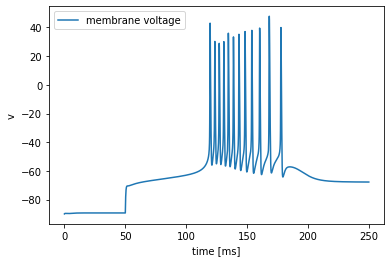

In [3]:
# time = 210 ms
# I = -2.5 * nA
plot(statemon.t/ms, statemon.v[0]/mV, label='membrane voltage')
legend()
xlabel('time [ms]')
ylabel('v')

Text(0, 0.5, 'gates dynamics')

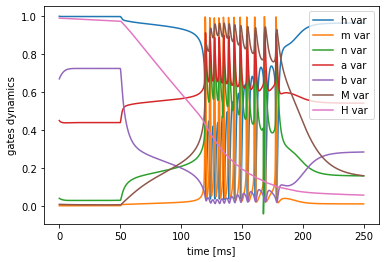

In [8]:
plot(statemon.t/ms, statemon.h[0], label='h var')
plot(statemon.t/ms, statemon.m[0], label='m var')
plot(statemon.t/ms, statemon.n[0], label='n var')
plot(statemon.t/ms, statemon.a[0], label='a var')
plot(statemon.t/ms, statemon.b[0], label='b var')
plot(statemon.t/ms, statemon.M[0], label='M var')
plot(statemon.t/ms, statemon.H[0], label='H var')
legend()
xlabel('time [ms]')
ylabel('gates dynamics')